# Prepare MTurk data
In which we prepare the data in batches to send to MTurk.

Relying on the following tutorials to survive:

- https://blog.mturk.com/tutorial-a-beginners-guide-to-crowdsourcing-ml-training-data-with-python-and-mturk-d8df4bdf2977
- https://ericscrivner.me/2015/04/mturk-python-guide-part-2/

In [1]:
import codecs

## Generate qualification test

In [17]:
q_file = '../../data/mturk_test/mturk_reading_comprehension_questions.xml'
a_file = '../../data/mturk_test/mturk_reading_comprehension_answers.xml'
q_lines = ''.join([l for l in codecs.open(q_file, 'r', encoding='utf-8')])
a_lines = ''.join([l for l in codecs.open(a_file, 'r', encoding='utf-8')])

In [15]:
print(q_lines)

<QuestionForm xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/QuestionForm.xsd">
<!-- Questions pulled from here: https://www.123teachme.com/learn_spanish/ -->
  <Overview>
    <Title>Reading comprehension test</Title>
    <Text>After taking this qualification test, you may be redirected away from our HIT. If this occurs, please search "toponym annotation" to take our test.
	</Text>
  </Overview>
  <Question>
    <QuestionIdentifier>question1</QuestionIdentifier>
    <IsRequired>true</IsRequired>
    <QuestionContent>
      <Text>
          Mi padre, mi madre y yo fuimos al circo. Vi a los payasos y a las fieras.
El circo me gustó mucho. Después nos vinimos a mi casa.
        
          ¿Qué vi en el circo?
        </Text>
    </QuestionContent>
    <AnswerSpecification>
      <SelectionAnswer>
        <StyleSuggestion>radiobutton</StyleSuggestion>
        <Selections>
          <Selection>
            <SelectionIdentifier>1</SelectionIdentifier>
    

In [6]:
key_file = '../../data/mturk_test/rootkey.csv'
access_keys = [l.split('=')[1].strip() for l in open(key_file)]

In [10]:
import boto3
MTURK_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'
mturk = boto3.client('mturk',
   aws_access_key_id = access_keys[0],
   aws_secret_access_key = access_keys[1],
   region_name='us-east-1',
   endpoint_url = MTURK_SANDBOX
)
print('I have $%s in my account'%(mturk.get_account_balance()['AvailableBalance']))

I have $10000.00 in my account


Let's try making a qualification in the Sandbox.

In [18]:
mturk.create_qualification_type(
    Name='Reading comprehension test//Examen de comprensión lectora',
    Keywords='reading comprehension,comprensión lectora,español',
    Description='Read each passage and answer the following question.//Lee el pasaje y responde la siguiente pregunta.',
    QualificationTypeStatus='Active',
    RetryDelayInSeconds=60,
    Test=q_lines,
    AnswerKey=a_lines,
    TestDurationInSeconds=600,
)

RequestError: An error occurred (RequestError) when calling the CreateQualificationType operation: You have already created a QualificationType with this name. A QualificationType's name must be unique among all of the QualificationTypes created by the same user. (1523486338845 s)

Whoops! That's what happens when you try to make multiple qualifications.

1 fake test later...let's download the results.

In [20]:
','.join(dir(mturk))

u'_PY_TO_OP_NAME,__class__,__delattr__,__dict__,__doc__,__format__,__getattr__,__getattribute__,__hash__,__init__,__module__,__new__,__reduce__,__reduce_ex__,__repr__,__setattr__,__sizeof__,__str__,__subclasshook__,__weakref__,_cache,_client_config,_convert_to_request_dict,_emit_api_params,_endpoint,_exceptions,_exceptions_factory,_get_waiter_config,_load_exceptions,_loader,_make_api_call,_register_handlers,_request_signer,_response_parser,_serializer,_service_model,accept_qualification_request,approve_assignment,associate_qualification_with_worker,can_paginate,create_additional_assignments_for_hit,create_hit,create_hit_type,create_hit_with_hit_type,create_qualification_type,create_worker_block,delete_hit,delete_qualification_type,delete_worker_block,disassociate_qualification_from_worker,exceptions,generate_presigned_url,get_account_balance,get_assignment,get_file_upload_url,get_hit,get_paginator,get_qualification_score,get_qualification_type,get_waiter,list_assignments_for_hit,list_b

In [23]:
hits = mturk.list_hits()['HITs']
print(len(hits))

10


In [34]:
for h in hits:
    hit_id = h['HITId']
    assignments = mturk.list_assignments_for_hit(HITId=hit_id, AssignmentStatuses=['Submitted'])
    print(assignments)

{u'NumResults': 1, u'Assignments': [{u'AutoApprovalTime': datetime.datetime(2018, 4, 14, 19, 7, 3, tzinfo=tzlocal()), u'AssignmentId': u'37UQDCYH6ZZPUOQ3UYF675IT4DQV7N', u'WorkerId': u'ANZZ8OMN0ORAL', u'AcceptTime': datetime.datetime(2018, 4, 11, 19, 6, 59, tzinfo=tzlocal()), u'HITId': u'3DA79LNS5AZQTTNXXP7Z4MNCSIF3T9', u'Answer': u'<?xml version="1.0" encoding="ASCII"?><QuestionFormAnswers xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/QuestionFormAnswers.xsd"><Answer><QuestionIdentifier>topos</QuestionIdentifier><FreeText> blah</FreeText></Answer></QuestionFormAnswers>', u'AssignmentStatus': u'Submitted', u'SubmitTime': datetime.datetime(2018, 4, 11, 19, 7, 3, tzinfo=tzlocal())}], u'NextToken': u'p1:7DCJACRMyNu1+6smGOfATrVjXFYyPVUQeTosm26s/gbNpg5D+br9Xjqt6or8Sg==', 'ResponseMetadata': {'RetryAttempts': 0, 'HTTPStatusCode': 200, 'RequestId': '7c132fbb-6f31-40ec-9f5c-86b1673e8cd3', 'HTTPHeaders': {'x-amzn-requestid': '7c132fbb-6f31-40ec-9f5c-86b1673e

OK! Now we know how to retrieve results. How about posting the HIT procedurally rather than manually?

## Organize post data
Let's get some sample posts, process them, and use them to set up a job.

In [62]:
import pandas as pd
import xlrd
annotated_file = '../../data/facebook-maria/annotations/annotator_1/Guayama_Early.xlsx'
annotated_posts = xlrd.open_workbook(annotated_file)
annotated_sheet = annotated_posts.sheets()[0]
print('%d x %d cells'%(annotated_sheet.nrows, annotated_sheet.ncols))
annotated_vals = [pd.DataFrame([annotated_sheet.cell(r,c).value for c in range(annotated_sheet.ncols)]).transpose() for r in range(annotated_sheet.nrows)]
annotated_data = pd.concat(annotated_vals[1:])
annotated_data.columns = annotated_vals[0].values[0]
annotated_data.index = pd.np.arange(annotated_data.shape[0])
annotated_data.head()

48 x 33 cells


,status_id,status_message,TOPO_1,TOPO_2,TOPO_3,TOPO_4,TOPO_5,TOPO_6,TOPO_7,TOPO_8,...,PII_12,PII_13,PII_14,PII_15,PII_16,PII_17,PII_18,PII_19,PII_20,notes
0,1773209126315380_1774161472886812,Alguien Sabe de Carite Bo Los Cafeitos. No se ...,Carite(4467968),Bo Los Cafeitos(UN),,,,,,,...,,,,,,,,,,
1,1773209126315380_1773719562931003,Estoy buscando a mi abuela María Ramírez y Alf...,iglesia por la puente(VAGUE),cancha de básquetbol(VAGUE),Arroyo(4467743),,,,,,...,,,,,,,,,,
2,1773209126315380_1774545312848428,Alguien sabe de olimpo Calle 7???? Tango a mi ...,Olimpo(7274960),Calle7(UN),,,,,,,...,,,,,,,,,,
3,1773209126315380_1774028619566764,Alguien sabe quién son lo refugiado de machete...,machete(4467969),,,,,,,,...,,,,,,,,,,
4,1773209126315380_1774467716189521,Nesecito saber de mi fam ellos son de las parc...,las parcelas nuevas de barranca(UN),,,,,,,,...,,,,,,,,,,


In [63]:
annotated_data

,status_id,status_message,TOPO_1,TOPO_2,TOPO_3,TOPO_4,TOPO_5,TOPO_6,TOPO_7,TOPO_8,...,PII_12,PII_13,PII_14,PII_15,PII_16,PII_17,PII_18,PII_19,PII_20,notes
0,1773209126315380_1774161472886812,Alguien Sabe de Carite Bo Los Cafeitos. No se ...,Carite(4467968),Bo Los Cafeitos(UN),,,,,,,...,,,,,,,,,,
1,1773209126315380_1773719562931003,Estoy buscando a mi abuela María Ramírez y Alf...,iglesia por la puente(VAGUE),cancha de básquetbol(VAGUE),Arroyo(4467743),,,,,,...,,,,,,,,,,
2,1773209126315380_1774545312848428,Alguien sabe de olimpo Calle 7???? Tango a mi ...,Olimpo(7274960),Calle7(UN),,,,,,,...,,,,,,,,,,
3,1773209126315380_1774028619566764,Alguien sabe quién son lo refugiado de machete...,machete(4467969),,,,,,,,...,,,,,,,,,,
4,1773209126315380_1774467716189521,Nesecito saber de mi fam ellos son de las parc...,las parcelas nuevas de barranca(UN),,,,,,,,...,,,,,,,,,,
5,1773209126315380_1773426966293596,Alguien sabe de La Loma del Viento? Mi abuela ...,La Loma del Viento(5184347323),,,,,,,,...,,,,,,,,,,
6,1773209126315380_1774470146189278,Alguien sabe de Urb parque interamericana ??,Urb parque interamericana(508498628),,,,,,,,...,,,,,,,,,,
7,1773209126315380_1773358086300484,Información sobre las el sector las cuevas de ...,sector las cuevas(UN),Guamani(4467972),Guayama(4467974),Carite(4467968),,,,,...,,,,,,,,,,
8,1773209126315380_1774082266228066,Mi gente si tienes fotos de la Urbanización CH...,Urbanización CHALETS BRISAS DEL MAR(UN),detrás del parque(VAGUE),,,,,,,...,,,,,,,,,,
9,1773209126315380_1774482312854728,Alguna información sobre Hacienda Valle Guaman...,Hacienda Valle Guamaní(UN),al lado de Alpla Caribe(UN),,,,,,,...,,,,,,,,,,


Let's choose 5 example posts to provide as annotator data.

We want two easy posts, two harder posts, and one null post.

In [71]:
from unidecode import unidecode
sample_idx = [46, 29, 30, 7, 13]
sample_txt = annotated_data.loc[sample_idx, 'status_message'].values
print(unidecode('\n'.join(sample_txt)))

Saludos, ayer pude comunicarme con mis familiares, he recibido informacion que en Guayama hay danos estructurales pero que la gente esta bien. Se que no les voy a quitar la angustia de escucharlos pero si les puedo dar un poco de tranquilidad diciendoles que estan bien. Un abrazo !Dios los bendiga!
Mi gente pude bajar el app. Simple radio y tengo noti uno en vivo. Escuche en zello q el alcalde de guayama va a hablar a las 5pm. No se si es verdad, pero si escucho algo lo pondre live.
Mi mama Ines Junior , Angie, Gloria, Tati . Green Hills, Puerto de Jobos y Costa Azul . Por favor alguna informacion [?]
Informacion sobre las el sector las cuevas de Guamani en Guayama por favor y de carite?????
Por favor vean este noticiero dar a informacion para la isla y sus estudiantes


We can replace the names with placeholders to protect PII.

In [72]:
sample_txt_names = ['Ines Junior', 'Angie', 'Gloria', 'Tati']
sample_txt_clean = []
for s in sample_txt:
    for n in sample_txt_names:
        s = s.replace(n, 'NOMBRE')
    sample_txt_clean.append(s)
print(unidecode('\n'.join(sample_txt_clean)))

Saludos, ayer pude comunicarme con mis familiares, he recibido informacion que en Guayama hay danos estructurales pero que la gente esta bien. Se que no les voy a quitar la angustia de escucharlos pero si les puedo dar un poco de tranquilidad diciendoles que estan bien. Un abrazo !Dios los bendiga!
Mi gente pude bajar el app. Simple radio y tengo noti uno en vivo. Escuche en zello q el alcalde de guayama va a hablar a las 5pm. No se si es verdad, pero si escucho algo lo pondre live.
Mi mama NOMBRE , NOMBRE, NOMBRE, NOMBRE . Green Hills, Puerto de Jobos y Costa Azul . Por favor alguna informacion [?]
Informacion sobre las el sector las cuevas de Guamani en Guayama por favor y de carite?????
Por favor vean este noticiero dar a informacion para la isla y sus estudiantes


Looks good! I think we can upload these.

In [80]:
import re
out_file = '../../data/mturk_test/pilot_test.csv'
sample_idx = [46, 29, 30, 7, 13]
sample_txt = annotated_data.loc[sample_idx, ['status_id', 'status_message']]
name_matcher = re.compile('|'.join(sample_txt_names))
# clean unicode
sample_txt.loc[:, 'status_message'] = sample_txt.loc[:, 'status_message'].apply(lambda x: unidecode(x))
# clean names
sample_txt.loc[:, 'status_message'] = sample_txt.loc[:, 'status_message'].apply(lambda x: name_matcher.sub('NOMBRE', x))
sample_txt.rename(columns={'status_message' : 'post'}, inplace=True)
sample_txt.to_csv(out_file, sep=',', quotechar='"', index=False, encoding='utf-8')

## Move to actual MTurk
Now let's create the same qualification test in an actual MTurk instance.

In [89]:
import boto3
key_file = '../../data/mturk_test/rootkey.csv'
access_keys = [l.split('=')[1].strip() for l in open(key_file)]
# MTURK_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'
MTURK = 'https://mturk-requester.us-east-1.amazonaws.com'
mturk = boto3.client('mturk',
   aws_access_key_id = access_keys[0],
   aws_secret_access_key = access_keys[1],
   region_name='us-east-1',
   endpoint_url = MTURK
)
print(mturk)
print('I have $%s in my account'%(mturk.get_account_balance()['AvailableBalance']))

I have $0.00 in my account


Make the qualification.

In [90]:
import codecs
q_file = '../../data/mturk_test/mturk_reading_comprehension_questions.xml'
a_file = '../../data/mturk_test/mturk_reading_comprehension_answers.xml'
q_lines = ''.join([l for l in codecs.open(q_file, 'r', encoding='utf-8')])
a_lines = ''.join([l for l in codecs.open(a_file, 'r', encoding='utf-8')])

In [91]:
mturk.create_qualification_type(
    Name='Reading comprehension test//Examen de comprensión lectora',
    Keywords='reading comprehension,comprensión lectora,español',
    Description='Read each passage and answer the following question.//Lee el pasaje y responde la siguiente pregunta.',
    QualificationTypeStatus='Active',
    RetryDelayInSeconds=60,
    Test=q_lines,
    AnswerKey=a_lines,
    TestDurationInSeconds=600,
)

{u'QualificationType': {u'AnswerKey': u'<AnswerKey xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/AnswerKey.xsd">\n    <Question>\n        <QuestionIdentifier>question1</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>1</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question2</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>2</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question3</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>2</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question4</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionI

## Pilot 2.0: Location identification, location mapping test
We just tried the pilot test and got mixed results, so we're going to simplify!

- Have one set of annotators extract all toponyms from the text.
- Have a second set of annotators geolocate all the extracted toponyms.

In [2]:
location_extraction_q_file = '../../data/mturk_test/mturk_location_identification_questions.xml'
location_extraction_a_file = '../../data/mturk_test/mturk_location_identification_answers.xml'
q_lines = ''.join([l for l in codecs.open(location_extraction_q_file, 'r', encoding='utf-8')])
a_lines = ''.join([l for l in codecs.open(location_extraction_a_file, 'r', encoding='utf-8')])

In [6]:
import boto3
key_file = '../../data/mturk_test/rootkey.csv'
access_keys = [l.split('=')[1].strip() for l in open(key_file)]
# sandbox first
MTURK_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'
mturk = boto3.client('mturk',
   aws_access_key_id = access_keys[0],
   aws_secret_access_key = access_keys[1],
   region_name='us-east-1',
   endpoint_url = MTURK_SANDBOX
)
print(mturk)
print('I have $%s in my account'%(mturk.get_account_balance()['AvailableBalance']))

I have $10000.00 in my account


In [7]:
mturk.create_qualification_type(
    Name='Location identification test//Examen de identificación de los lugars',
    Keywords='reading comprehension,comprensión lectora,español',
    Description='Read each statement and choose the text that could be a location name. // Lea cada declaración y elija el texto que puede ser un nombre de un lugar.',
    QualificationTypeStatus='Active',
    RetryDelayInSeconds=60,
    Test=q_lines,
    AnswerKey=a_lines,
    TestDurationInSeconds=600,
)

{u'QualificationType': {u'AnswerKey': u'<AnswerKey xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/AnswerKey.xsd">\n    <Question>\n        <QuestionIdentifier>question1</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>1</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question2</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>4</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question3</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>2</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question4</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionI

In [8]:
location_extraction_q_file = '../../data/mturk_test/mturk_map_location_questions.xml'
location_extraction_a_file = '../../data/mturk_test/mturk_map_location_answers.xml'
q_lines = ''.join([l for l in codecs.open(location_extraction_q_file, 'r', encoding='utf-8')])
a_lines = ''.join([l for l in codecs.open(location_extraction_a_file, 'r', encoding='utf-8')])
mturk.create_qualification_type(
    Name='Locate place names on a map. // Buscar los nombres de los lugars en un mapa.',
    Keywords='annotation,locations,map,geolocation,anotación,lugars,mapa',
    Description='From each post, locate the place names on a map. // En cada publicación, ubicar los nombres de los lugars en un mapa.',
    QualificationTypeStatus='Active',
    RetryDelayInSeconds=60,
    Test=q_lines,
    AnswerKey=a_lines,
    TestDurationInSeconds=600,
)

{u'QualificationType': {u'AnswerKey': u'<AnswerKey xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/AnswerKey.xsd">\n    <Question>\n        <QuestionIdentifier>question1</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>4</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question2</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>1</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question3</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>2</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question4</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionI

### Real qualification tests

In [11]:
import boto3
key_file = '../../data/mturk_test/rootkey.csv'
access_keys = [l.split('=')[1].strip() for l in open(key_file)]
# MTURK_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'
MTURK = 'https://mturk-requester.us-east-1.amazonaws.com'
mturk = boto3.client('mturk',
   aws_access_key_id = access_keys[0],
   aws_secret_access_key = access_keys[1],
   region_name='us-east-1',
   endpoint_url = MTURK
)
print(mturk)
print('I have $%s in my account'%(mturk.get_account_balance()['AvailableBalance']))

I have $0.00 in my account


In [5]:
mturk.create_qualification_type(
    Name='Location identification test//Examen de identificación de los lugars',
    Keywords='reading comprehension,comprensión lectora,español',
    Description='Read each statement and choose the text that could be a location name. // Lea cada declaración y elija el texto que puede ser un nombre de un lugar.',
    QualificationTypeStatus='Active',
    RetryDelayInSeconds=60,
    Test=q_lines,
    AnswerKey=a_lines,
    TestDurationInSeconds=600,
)

{u'QualificationType': {u'AnswerKey': u'<AnswerKey xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/AnswerKey.xsd">\n    <Question>\n        <QuestionIdentifier>question1</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>1</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question2</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>4</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question3</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>2</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question4</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionI

In [9]:
map_location_q_file = '../../data/mturk_test/mturk_map_location_questions.xml'
map_location_a_file = '../../data/mturk_test/mturk_map_location_questions.xml'

In [12]:
mturk.create_qualification_type(
    Name='Locate place names on a map. // Buscar los nombres de los lugars en un mapa.',
    Keywords='annotation,locations,map,geolocation,anotación,lugars,mapa',
    Description='From each post, locate the place names on a map. // En cada publicación, ubicar los nombres de los lugars en un mapa.',
    QualificationTypeStatus='Active',
    RetryDelayInSeconds=60,
    Test=q_lines,
    AnswerKey=a_lines,
    TestDurationInSeconds=600,
)

{u'QualificationType': {u'AnswerKey': u'<AnswerKey xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/AnswerKey.xsd">\n    <Question>\n        <QuestionIdentifier>question1</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>4</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question2</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>1</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question3</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionIdentifier>2</SelectionIdentifier>\n            <AnswerScore>1</AnswerScore>\n        </AnswerOption>\n    </Question>\n    <Question>\n        <QuestionIdentifier>question4</QuestionIdentifier>\n        <AnswerOption>\n            <SelectionI

### Choose data for pilot tests

In [20]:
import pandas as pd
import data_helpers
reload(data_helpers)
from data_helpers import read_excel_as_dataframe
annotated_file = '../../data/facebook-maria/annotations/annotator_1/Guayama_Early.xlsx'
annotated_data = read_excel_as_dataframe(annotated_file)[0]
annotated_data

,status_id,status_message,TOPO_1,TOPO_2,TOPO_3,TOPO_4,TOPO_5,TOPO_6,TOPO_7,TOPO_8,...,PII_12,PII_13,PII_14,PII_15,PII_16,PII_17,PII_18,PII_19,PII_20,notes
0,1773209126315380_1774161472886812,Alguien Sabe de Carite Bo Los Cafeitos. No se ...,Carite(4467968),Bo Los Cafeitos(UN),,,,,,,...,,,,,,,,,,
1,1773209126315380_1773719562931003,Estoy buscando a mi abuela María Ramírez y Alf...,iglesia por la puente(VAGUE),cancha de básquetbol(VAGUE),Arroyo(4467743),,,,,,...,,,,,,,,,,
2,1773209126315380_1774545312848428,Alguien sabe de olimpo Calle 7???? Tango a mi ...,Olimpo(7274960),Calle7(UN),,,,,,,...,,,,,,,,,,
3,1773209126315380_1774028619566764,Alguien sabe quién son lo refugiado de machete...,machete(4467969),,,,,,,,...,,,,,,,,,,
4,1773209126315380_1774467716189521,Nesecito saber de mi fam ellos son de las parc...,las parcelas nuevas de barranca(UN),,,,,,,,...,,,,,,,,,,
5,1773209126315380_1773426966293596,Alguien sabe de La Loma del Viento? Mi abuela ...,La Loma del Viento(5184347323),,,,,,,,...,,,,,,,,,,
6,1773209126315380_1774470146189278,Alguien sabe de Urb parque interamericana ??,Urb parque interamericana(508498628),,,,,,,,...,,,,,,,,,,
7,1773209126315380_1773358086300484,Información sobre las el sector las cuevas de ...,sector las cuevas(UN),Guamani(4467972),Guayama(4467974),Carite(4467968),,,,,...,,,,,,,,,,
8,1773209126315380_1774082266228066,Mi gente si tienes fotos de la Urbanización CH...,Urbanización CHALETS BRISAS DEL MAR(UN),detrás del parque(VAGUE),,,,,,,...,,,,,,,,,,
9,1773209126315380_1774482312854728,Alguna información sobre Hacienda Valle Guaman...,Hacienda Valle Guamaní(UN),al lado de Alpla Caribe(UN),,,,,,,...,,,,,,,,,,


In [50]:
print('\n'.join(['%d %s'%(i, s) for i, s in enumerate(annotated_data.loc[:, 'status_message'].values)]))
location_annotation_status_idx = [1, 5, 6, 18, 46]
map_location_status_idx = [2, 7, 12, 37, 43]
print('location annotation statuses')
print(annotated_data.iloc[location_annotation_status_idx, :].loc[:, ['status_id', 'status_message', 'TOPO_1', 'TOPO_2', 'TOPO_3', 'TOPO_4']])
print('map location statuses')
print(annotated_data.iloc[map_location_status_idx, :])

0 Alguien Sabe de Carite Bo Los Cafeitos. No se nada de mis Padres Ciprian Ramos y Dolores Perez si alguien tiene informacion Porfavor deja me saber
1 Estoy buscando a mi abuela María Ramírez y Alfonso Baez de San Martin. Estaban en una iglesia por la puente... mi dicen que estaban en la cancha de básquetbol pero el roof se cayó y lo mandaron para Arroyo ... por favor si tiene información communicate conmigo gracias 💚
2 Alguien sabe de olimpo Calle 7???? Tango a mi abuelo tio y tia que no se encuentran
3 Alguien sabe quién son lo refugiado de machete por favor o tendrá imágenes de los cundos
4 Nesecito saber de mi fam ellos son de las parcelas nuevas de barranca 😭💔🇵🇷
5 Alguien sabe de La Loma del Viento? Mi abuela se llama Rosa Campos.
6 Alguien sabe de Urb parque interamericana ??
7 Información sobre las el sector las cuevas de Guamani en Guayama por favor y de carite?????😢😢😢😢😢😢😢
8 Mi gente si tienes fotos de la Urbanización CHALETS BRISAS DEL MAR acceso controlado detrás del parque P

In [51]:
import re
from unidecode import unidecode
location_annotation_file = '../../data/mturk_test/mturk_location_identification_pilot.csv'
map_annotation_file = '../../data/mturk_test/mturk_map_location_pilot.csv'
names = ['María Ramírez', 'Alfonso Baez', 'San Martin', 
         'Rosa Campos', 'nohely Montañez', 'Fela Vazquez', 
         'Vazquez', 'Wigberto Cruz', 'Enid Ortiz Vazquez',
         'Evelyn']
name_matcher = re.compile('|'.join(names))
topo_cols = filter(lambda x: 'TOPO' in x, annotated_data.columns)

## clean statuses and topo words
annotated_data_clean = annotated_data.copy()
annotated_data_clean.loc[:, 'status_message'] = annotated_data_clean.loc[:, 'status_message'].apply(lambda x: name_matcher.sub('NOMBRE', x.encode('utf-8')))
annotated_data_clean.loc[:, 'status_message'] = annotated_data_clean.loc[:, 'status_message'].apply(lambda x: unidecode(x.decode('utf-8')))
annotated_data_clean.rename(columns={'status_message' : 'post'}, inplace=True)
for c in topo_cols:
    annotated_data_clean.loc[:, c] = annotated_data_clean.loc[:, c].apply(lambda x: x.split('(')[0])
location_annotation_status = annotated_data_clean.iloc[location_annotation_status_idx, :].loc[:, ['status_id', 'post']]
map_location_status = annotated_data_clean.iloc[map_location_status_idx, :].loc[:, ['status_id', 'post']+topo_cols]

## write to file
location_annotation_status.to_csv(location_annotation_file, sep=',', quotechar='"', index=False, encoding='utf-8')
map_location_status.to_csv(map_annotation_file, sep=',', quotechar='"', index=False, encoding='utf-8')

## Examine results
Now that the results are in, let's see how the annotations look.

In [3]:
import boto3
key_file = '../../data/mturk_test/rootkey.csv'
access_keys = [l.split('=')[1].strip() for l in open(key_file)]
# MTURK_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'
MTURK = 'https://mturk-requester.us-east-1.amazonaws.com'
mturk = boto3.client('mturk',
   aws_access_key_id = access_keys[0],
   aws_secret_access_key = access_keys[1],
   region_name='us-east-1',
   endpoint_url = MTURK
)
print(mturk)
print('I have $%s in my account'%(mturk.get_account_balance()['AvailableBalance']))

I have $0.00 in my account


In [50]:
hit_data.columns

Index(['AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'CreationTime', 'Description', 'Expiration', 'HITGroupId', 'HITId',
       'HITLayoutId', 'HITReviewStatus', 'HITStatus', 'HITTypeId', 'Keywords',
       'MaxAssignments', 'NumberOfAssignmentsAvailable',
       'NumberOfAssignmentsCompleted', 'NumberOfAssignmentsPending',
       'QualificationRequirements', 'Question', 'RequesterAnnotation',
       'Reward', 'Title'],
      dtype='object')

In [6]:
import pandas as pd
all_hits = mturk.list_hits()['HITs']
hit_data = pd.DataFrame(list(map(pd.Series, all_hits)))
hit_data

,AssignmentDurationInSeconds,AutoApprovalDelayInSeconds,CreationTime,Description,Expiration,HITGroupId,HITId,HITLayoutId,HITReviewStatus,HITStatus,...,Keywords,MaxAssignments,NumberOfAssignmentsAvailable,NumberOfAssignmentsCompleted,NumberOfAssignmentsPending,QualificationRequirements,Question,RequesterAnnotation,Reward,Title
0,7200,259200,2018-04-23 19:11:10-04:00,"From each post, locate the place names on a ma...",2018-04-30 19:11:10-04:00,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3UQVX1UPFTL0S2UNVN5JO5IHF3S022,3VIMNYRPAOYI3N4JZ1039F6TXDY7W4,NotReviewed,Reviewable,...,"annotation,locations,map,geolocation,anotación...",4,0,0,0,[{'QualificationTypeId': '3RFK03H8OMIIMTKOWI5L...,"<?xml version=""1.0""?>\n<HTMLQuestion xmlns=""ht...",BatchId:3206216;OriginalHitTemplateId:926158632;,0.25,Locate place names on a map. // Buscar los nom...
1,7200,259200,2018-04-23 19:11:10-04:00,"From each post, locate the place names on a ma...",2018-04-30 19:11:10-04:00,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3CVBMEMMXCKIP3XPZ7TZQOY6C0G7HR,3VIMNYRPAOYI3N4JZ1039F6TXDY7W4,NotReviewed,Reviewable,...,"annotation,locations,map,geolocation,anotación...",4,0,0,0,[{'QualificationTypeId': '3RFK03H8OMIIMTKOWI5L...,"<?xml version=""1.0""?>\n<HTMLQuestion xmlns=""ht...",BatchId:3206216;OriginalHitTemplateId:926158632;,0.25,Locate place names on a map. // Buscar los nom...
2,7200,259200,2018-04-23 19:11:10-04:00,"From each post, locate the place names on a ma...",2018-04-30 19:11:10-04:00,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3QE4DGPGBSF76KKVD3DA2C2V6YD4G5,3VIMNYRPAOYI3N4JZ1039F6TXDY7W4,NotReviewed,Reviewable,...,"annotation,locations,map,geolocation,anotación...",4,0,0,0,[{'QualificationTypeId': '3RFK03H8OMIIMTKOWI5L...,"<?xml version=""1.0""?>\n<HTMLQuestion xmlns=""ht...",BatchId:3206216;OriginalHitTemplateId:926158632;,0.25,Locate place names on a map. // Buscar los nom...
3,7200,259200,2018-04-23 19:11:10-04:00,"From each post, locate the place names on a ma...",2018-04-30 19:11:10-04:00,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,39I4RL8QGKLL6GF6X9VSNCEWLYQ4H4,3VIMNYRPAOYI3N4JZ1039F6TXDY7W4,NotReviewed,Reviewable,...,"annotation,locations,map,geolocation,anotación...",4,0,0,0,[{'QualificationTypeId': '3RFK03H8OMIIMTKOWI5L...,"<?xml version=""1.0""?>\n<HTMLQuestion xmlns=""ht...",BatchId:3206216;OriginalHitTemplateId:926158632;,0.25,Locate place names on a map. // Buscar los nom...
4,7200,259200,2018-04-23 19:11:10-04:00,"From each post, locate the place names on a ma...",2018-04-30 19:11:10-04:00,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3UYRNV2KIU3EZDOJCAGI98RX9WUN82,3VIMNYRPAOYI3N4JZ1039F6TXDY7W4,NotReviewed,Reviewable,...,"annotation,locations,map,geolocation,anotación...",4,0,0,0,[{'QualificationTypeId': '3RFK03H8OMIIMTKOWI5L...,"<?xml version=""1.0""?>\n<HTMLQuestion xmlns=""ht...",BatchId:3206216;OriginalHitTemplateId:926158632;,0.25,Locate place names on a map. // Buscar los nom...
5,7200,259200,2018-04-23 19:09:45-04:00,"From each post, extract all locations. // En c...",2018-04-30 19:09:45-04:00,3W718UE9EUYEW71SX2YCRZVEBSV8K5,39AYGO6AFGORVZ5VJVJKPUV6314N6G,NaN,NotReviewed,Reviewable,...,"annotation,locations,anotación,lugars",4,0,0,0,[{'QualificationTypeId': '3CA6FK7UX9ET1E5IP5WW...,"<?xml version=""1.0""?>\n<ExternalQuestion xmlns...",BatchId:3206210;OriginalHitTemplateId:926158632;,0.25,Find locations in text. // Buscar los lugars e...
6,7200,259200,2018-04-23 19:09:45-04:00,"From each post, extract all locations. // En c...",2018-04-30 19:09:45-04:00,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3XAOZ9UYR0VHRAHQTHZKYSZU01BQ18,NaN,NotReviewed,Reviewable,...,"annotation,locations,anotación,lugars",4,0,0,0,[{'QualificationTypeId': '3CA6FK7UX9ET1E5IP5WW...,"<?xml version=""1.0""?>\n<ExternalQuestion xmlns...",BatchId:3206210;OriginalHitTemplateId:926158632;,0.25,Find locations in text. // Buscar los lugars e...
7,7200,259200,2018-04-23 19:09:45-04:00,"From each post, extract all locations. // En c...",2018-04-30 19:09:45-04:00,3W718UE9EUYEW71SX2YCRZVEBSV8K5,39KMGHJ4R0ETWSR9G0155HP2I5800I,NaN,NotReviewed,Reviewa

In [43]:
import xmltodict
def extract_results_from_hit_group(mturk, hit_data):
    """
    Returns:
    --------
    results : list
    group ID | assignment ID | status ID | answer data
    """
    results = []
    hit_group_IDs = hit_data.loc[:, 'HITGroupId'].unique()
    for hit_group_ID in hit_group_IDs:
        hit_group_results = []
        hit_group_data = hit_data[hit_data.loc[:, 'HITGroupId']==hit_group_ID]
        hit_ids = hit_group_data.loc[:, 'HITId']
        for hit_id in hit_ids:
            assignments = mturk.list_assignments_for_hit(HITId=hit_id)['Assignments']
            for assignment in assignments:
                assignment_ID = assignment['AssignmentId']
                answer = assignment['Answer']
                # parse xml
                answer = xmltodict.parse(answer)['QuestionFormAnswers']['Answer']
                answer_pairs = list(map(lambda x: [x['QuestionIdentifier'], x['FreeText']], answer))
                answer_keys, answer_vals = zip(*answer_pairs)
                answer_series = pd.Series(answer_vals, index=answer_keys).fillna('', inplace=False)
                result_row = answer_series.copy()
                result_row.loc['group_ID'] = hit_group_ID
                result_row.loc['assignment_ID'] = assignment_ID
                hit_group_results.append(result_row)
        hit_group_df = pd.concat(hit_group_results, axis=1).transpose()
        results.append(hit_group_df)
    return results
#         print(assignments)

In [ ]:
mturk = '3X2YVV51PV8MB7DC5QYQQHHGO2T1WO'

In [44]:
hit_group_id = '3W718UE9EUYEW71SX2YCRZVEBSV8K5'
results = extract_results_from_hit_group(mturk, hit_data)
# join with status, original data (post, TOPO_1, etc.)

In [45]:
results[0]

,topo1_id,topo1_source,topo2_id,topo2_source,topo3_id,topo3_source,topo4_id,topo4_source,topo5_id,topo5_source,...,topo7_source,topo8_id,topo8_source,topo9_id,topo9_source,topo10_id,topo10_source,notes,group_ID,assignment_ID
0,336982562,O,vague,N,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3QRYMNZ7F0LZKHE15AWFOOI5RYJTNU
1,VAGUE,O,UN,G,,,,,,,...,,,,,,,,There are too many streets to narrow this down...,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3DH6GAKTY0TPISREI4U8RSHTGEBZY8
2,7274960,G,N,UN,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3GU1KF0O4K5ZRGWXL3IMSJHEL6PBPN
3,VAGUE,N,22160498,O,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,38YMOXR4MW3J5DC31YF99X3I02I6WT
4,4468410,O,,,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3N8OEVH1FTU1PA95A8AT93CNI07OOI
5,5184347324,O,,,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,317HQ483I9W9B3YQBYXBAHGWGH8NIC
6,5184347324,O,,,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,36H9ULYP64YTIM5FVSZYEDMNR5BFJ9
7,5184347324,O,,,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3RWE2M8QWJEY48HA78854DG0UNT0NW
8,4563564,G,,,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,33LK57MYLV9SM6F5JY2J96TSZTCZSR
9,7275050,G,,,,,,,,,...,,,,,,,,,31QBDMKNEQTPGDJAI2AD6Z8T0S08L8,3I0BTBYZAZPSG7LOEAHGLTE7Y7UY0H


In [47]:
results[1]

,topo1,topo2,topo3,topo4,topo5,topo6,topo7,topo8,topo9,topo10,notes,group_ID,assignment_ID
0,Arroyo,,,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3U5NZHP4LT69ITZJLVSIEUKCGJSPHF
1,una iglesia por la puente,la cancha de basquetbol,Arroyo,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3PJUZCGDJ8KVXVIJ122FFRRY8WL89P
2,una iglesia por la puente,la cancha de basquetbol,Arroyo,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3OF2M9AATISUYN2XEPTHIK2IIZ4ZKF
3,una iglesia,por la puente,la cancha de basquetbol,Arroyo,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3SB4CE2TJXZZHFTW1GS7RLJB5NCXA1
4,La Loma del Viento,,,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,358UUM7WR17X1H9MLEAVSCVX3YKR77
5,La Loma del Viento,,,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3OVR4I9USRN06TC361NOKA1IGAT4Q0
6,La Loma del Viento,,,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3VFJCI1K413GUAKNEHEPYP8Q214RGB
7,La Loma del Viento,,,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3X31TUMD7ZQ8NXZ7REWQ5QVLUKX1LW
8,Guayama,,,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,33JKGHPFYEYV7MOHWDV32ANDXQQMNP
9,Guayama,,,,,,,,,,,3W718UE9EUYEW71SX2YCRZVEBSV8K5,3VW04L3ZLVABDS1PCQKLBTU968KXX4


After processing the annotator data [here](get_annotated_google_sheets.py), we compare it with MTurk data shown above.

In [172]:
annotated_data_file = '../../data/facebook-maria/annotations/annotator_1/Guayama_Early_annotated.tsv'
annotated_data = pd.read_csv(annotated_data_file, sep='\t', index_col=False)
# convert all IDs to number
id_gold_matcher = re.compile('(?<=TOPO_)[0-9]+(?=_id)')
id_gold_cols = list(filter(lambda x: id_gold_matcher.search(x), annotated_data.columns))
annotated_data.loc[:, id_gold_cols] = annotated_data.loc[:, id_gold_cols].fillna(0, inplace=False)
## convert eligible IDs to int
for id_gold_col in id_gold_cols:
    annotated_data.loc[:, id_gold_col] = annotated_data.loc[:, id_gold_col].apply(lambda x: int(x) if (type(x) is str and x.isdigit()) else x)
annotated_data.loc[:, id_gold_cols].head(10)

,TOPO_1_id,TOPO_2_id,TOPO_3_id,TOPO_4_id,TOPO_5_id,TOPO_6_id,TOPO_7_id,TOPO_8_id,TOPO_9_id,TOPO_10_id
0,4467968,UN,-1,-1,-1,-1,-1,-1,-1,-1
1,VAGUE,VAGUE,4467743,-1,-1,-1,-1,-1,-1,-1
2,7274960,UN,-1,-1,-1,-1,-1,-1,-1,-1
3,4467969,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,UN,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,5184347323,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,508498628,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,UN,4467972,4467974,4467968,-1,-1,-1,-1,-1,-1
8,UN,VAGUE,-1,-1,-1,-1,-1,-1,-1,-1
9,UN,UN,-1,-1,-1,-1,-1,-1,-1,-1


### Combine MTurk annotation results and gold annotation results

Update: we have to download the batch results from the MTurk UI because we didn't provide the right `RequesterAnnotation` field (more details [here](https://stackoverflow.com/questions/28370134/boto-mechanical-turk-how-do-you-get-all-fields#28426910)).

In [120]:
map_location_results.loc[:, id_answer_cols].head()

,Answer.topo10_id,Answer.topo1_id,Answer.topo2_id,Answer.topo3_id,Answer.topo4_id,Answer.topo5_id,Answer.topo6_id,Answer.topo7_id,Answer.topo8_id,Answer.topo9_id
0,-1.0,VAGUE,22160498,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,VAGUE,UN,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,7274960,N,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,336982562,vague,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,5001737354,4467972,1.944794e+09,4467968.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [189]:
location_identification_results = pd.read_csv('../../data/mturk_test/mturk_location_identification_pilot_results.csv', index_col=False)
map_location_results = pd.read_csv('../../data/mturk_test/mturk_map_location_pilot_results.csv', index_col=False)
## fill NA values
map_location_results.fillna(-1, inplace=True)
location_identification_results.fillna(-1, inplace=True)
print(location_identification_results.columns)
# location_identification_results.head()
# convert all IDs to number
id_answer_matcher = re.compile('(?<=Answer\.topo)[0-9]+(?=_id)')
id_answer_cols = list(filter(lambda x: id_answer_matcher.search(x), map_location_results.columns))
for id_answer_col in id_answer_cols:
    map_location_results.loc[:, id_answer_col] = map_location_results.loc[:, id_answer_col].apply(lambda x: int(x) if (type(x) is float or (type(x) is str and x.isdigit())) else x)
    # fix N => UN
    map_location_results.loc[:, id_answer_col] = map_location_results.loc[:, id_answer_col].apply(lambda x: 'UN' if type(x) is str and x == 'N' else x)

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.status_id',
       'Input.post', 'Answer.notes', 'Answer.topo1', 'Answer.topo10',
       'Answer.topo2', 'Answer.topo3', 'Answer.topo4', 'Answer.topo5',
       'Answer.topo6', 'Answer.topo7', 'Answer.topo8', 'Answer.topo9',
       'Approve', 'Reject'],
      dtype='object')


In [191]:
# join on status ID
location_results_combined = pd.merge(location_identification_results, annotated_data, left_on='Input.status_id', right_on='status_id', how='inner')
map_location_results_combined = pd.merge(map_location_results, annotated_data, left_on='Input.status_id', right_on='status_id', how='inner')
location_results_combined.fillna('', inplace=True)
map_location_results_combined.fillna('', inplace=True)

In [187]:
import re
from itertools import product
from functools import reduce
import numpy as np
def compute_topo_matches(data, answer_match_str='(?<=Answer\.topo)[0-9]+$', gold_match_str='(?<=TOPO_)[0-9]+$', verbose=False):
    answer_matcher = re.compile(answer_match_str)
    gold_matcher = re.compile(gold_match_str)
    answer_cols = sorted(list(filter(lambda x: answer_matcher.search(x), data.columns)), key=lambda x: int(answer_matcher.search(x).group(0)))
    gold_cols = sorted(list(filter(lambda x: gold_matcher.search(x), data.columns)), key=lambda x: int(gold_matcher.search(x).group(0)))
    answer_overlap_means = []
    gold_overlap_means = []
    gold_recalls = []
    for d_id, d_group in data.groupby('status_id'):
        answer_topo_sets = d_group.loc[:, answer_cols].apply(lambda x: set(x[(x != '') & (x != -1)]), axis=1).values
        gold_topo_set = d_group.loc[:, gold_cols].apply(lambda x: set(x[(x != -1) & (x != '-1') & (x != '')]), axis=1).iloc[0]
        if(verbose):
            print('answer topo sets:')
            print(answer_topo_sets)
            print('gold topo set:')
            print(gold_topo_set)
        # answer overlap: pairwise agreement
        answer_overlap = []
        for i in range(len(d_group)):
            s_i = answer_topo_sets[i]
            for j in range(1, len(d_group)):
                s_j = answer_topo_sets[j]
                if(len(s_i) > 0 or len(s_j) > 0):
                    i_j_overlap = len(s_i & s_j) / max(len(s_i), len(s_j))
                    answer_overlap.append(i_j_overlap)
        answer_overlap_mean = np.mean(answer_overlap)
        answer_overlap_means.append(answer_overlap_mean)
        # gold overlap: (1) average overlap % (2) total recall
        if(len(gold_topo_set) > 0):
            gold_overlap = []
            for i in range(len(d_group)):
                s_i = answer_topo_sets[i]
                i_gold_overlap = len(s_i & gold_topo_set) / len(gold_topo_set)
                gold_overlap.append(i_gold_overlap)
            gold_overlap_mean = np.mean(gold_overlap)
            gold_overlap_means.append(gold_overlap_mean)
            answer_topo_superset = reduce(lambda x,y: x | y, answer_topo_sets)
            gold_recall = len(answer_topo_superset & gold_topo_set) / len(gold_topo_set)
            gold_recalls.append(gold_recall)
    answer_overlap_mean_macro = np.mean(answer_overlap_means)
    gold_overlap_mean_macro = np.mean(gold_overlap_means)
    gold_recall = np.mean(gold_recalls)
    return answer_overlap_mean_macro, gold_overlap_mean_macro, gold_recall

In [198]:
## location results
answer_overlap_mean_macro_loc, gold_overlap_mean_macro_loc, gold_recall_loc = compute_topo_matches(location_results_combined, verbose=True)
print('location test results:')
print('answer overlap mean = %.3E'%(answer_overlap_mean_macro_loc))
print('gold overlap mean = %.3E'%(gold_overlap_mean_macro_loc))
print('gold recall = %.3E'%(gold_recall_loc))

answer topo sets:
[{'La Loma del Viento'} {'La Loma del Viento'} {'La Loma del Viento'}
 {'La Loma del Viento'}]
gold topo set:
{'La Loma del Viento'}
answer topo sets:
[{'Calle la Milagrosa', 'El bario Corazon'}
 {'el barrio Corazon', 'Calle la Milagrosa'}
 {'Calle la Milagrosa', 'Corazon'} {'Calle la Milagrosa', 'Corazon'}]
gold topo set:
{'Calle la Milagrosa', 'barrio Corazon'}
answer topo sets:
[{'la cancha de basquetbol', 'una iglesia por la puente', 'Arroyo'}
 {'la cancha de basquetbol', 'una iglesia por la puente', 'Arroyo'}
 {'una iglesia', 'la cancha de basquetbol', 'por la puente', 'Arroyo'}
 {'Arroyo'}]
gold topo set:
{'cancha de básquetbol', 'iglesia por la puente', 'Arroyo'}
answer topo sets:
[{'Guayama'} {'Guayama'} {'Guayama'} {'Guayama'}]
gold topo set:
{'Guayama'}
answer topo sets:
[{'parque interamericana'} {'Urb parque interamericana'}
 {'Urb parque interamericana'} {'Urb parque interamericana'}]
gold topo set:
{'Urb parque interamericana'}
location test results:
ans

In [199]:
## map results
answer_overlap_mean_macro_map, gold_overlap_mean_macro_map, gold_recall_map = compute_topo_matches(map_location_results_combined,
                                                                                       answer_match_str='(?<=Answer\.topo)[0-9]+(?=_id)',
                                                                                       gold_match_str='(?<=TOPO_)[0-9]+(?=_id)',
                                                                                       verbose=True)
print('map test results:')
print('answer overlap mean = %.3E'%(answer_overlap_mean_macro_map))
print('gold overlap mean = %.3E'%(gold_overlap_mean_macro_map))
print('gold recall = %.3E'%(gold_recall_map))

answer topo sets:
[{4467968, 5001737354, 4467972, 1944794343}
 {4565936, 7268417, 7268344, 1944794343}
 {4467968, 'UN', 4467972, 1944794343} {4467968, 'VAGUE', 4467972, 4467974}]
gold topo set:
{4467968, 'UN', 4467972, 4467974}
answer topo sets:
[{4563564} {'UN'} {7275050} {4563990}]
gold topo set:
{7275050}
answer topo sets:
[{462592228} {462592228} {462592228} {462592228}]
gold topo set:
{462592228}
answer topo sets:
[{'VAGUE', 22160498} {'VAGUE', 'UN'} {7274960, 'UN'} {336982562, 'vague'}]
gold topo set:
{7274960, 'UN'}
answer topo sets:
[{5184347324} {5184347324} {4468410} {5184347324}]
gold topo set:
{5184347324}
map test results:
answer overlap mean = 5.417E-01
gold overlap mean = 5.750E-01
gold recall = 1.000E+00


## Final pilot test results

**Location identification**

- Inter-annotator agreement: 80.8%
- Mean annotator accuracy: 71.7%
- Mean annotator recall: 76.7%

**Map location**

- Inter-annotator agreement: 54.2%
- Mean annotator accuracy: 55.0%
- Mean annotator recall: 100%

It's easier to identify locations and harder to identify IDs. 

The discrepancy in recall is likely due to partial string matching (e.g. "el barrio Corazon" vs. "Corazon").

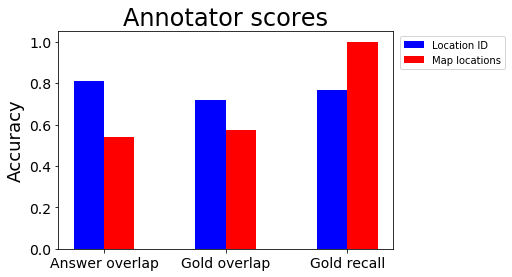

In [233]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# let's make this into a plot for posterity
bar_width = 0.25
bar_offset = 0.125
x = np.arange(0,3)
x_labels = ['Answer overlap', 'Gold overlap', 'Gold recall']
loc_scores = [answer_overlap_mean_macro_loc, gold_overlap_mean_macro_loc, gold_recall_loc]
map_scores = [answer_overlap_mean_macro_map, gold_overlap_mean_macro_map, gold_recall_map]
c1 = 'b'
c2 = 'r'
plt.bar(x-bar_offset, loc_scores, width=bar_width, color=c1, label='Location ID')
plt.bar(x+bar_offset, map_scores, width=bar_width, color=c2, label='Map locations')
plt.title('Annotator scores', fontsize=24)
plt.xticks(x, x_labels, fontsize=14)
plt.ylabel('Accuracy', fontsize=18)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=[1.35,1])
plt.show()

### Extra results
1. Time: How long did it take the average annotator to finish a HIT?

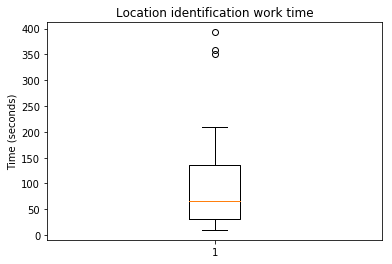

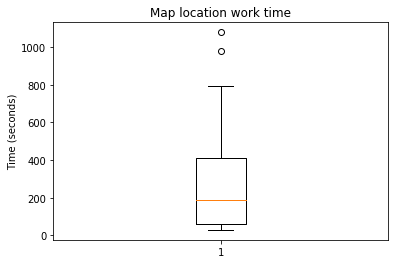

In [197]:
# list(map_location_results_combined.columns)
## location identification
loc_times = location_results_combined.loc[:, 'WorkTimeInSeconds'].values
map_times = map_location_results.loc[:, 'WorkTimeInSeconds']
plt.boxplot()
plt.title('Location identification work time')
plt.ylabel('Time (seconds)')
plt.show()
## map location
plt.boxplot()
plt.title('Map location work time')
plt.ylabel('Time (seconds)')
plt.show()

It almost always takes less time to find locations than to geolocate toponyms.